<a href="https://colab.research.google.com/github/zeev-haydar/ML-TuneHive/blob/model-development%2Fhaidar/model-dev/preprocessing-modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Dec 11 10:59:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Preprocessing and Modeling

## Import required modules

In [37]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
from keras.api.layers import Dense, Embedding, GRU, LeakyReLU, Concatenate, Masking, Layer, StringLookup, Normalization, BatchNormalization, Attention, Dropout
from keras.api import Input
from keras.api.models import Model
from keras.api.losses import SparseCategoricalCrossentropy
from keras.api.metrics import SparseCategoricalAccuracy, Mean, TopKCategoricalAccuracy
# from transformers.models.bert import TFBertTokenizer, TFBertEmbeddings  # embedding and tokenizer for description/nlp related stufff
from keras.api.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast

## Preprocessing

### Load CSV

In [3]:
# For Running in Google Colab
# "https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{file}"
url = "https://raw.githubusercontent.com/zeev-haydar/ML-TuneHive/main/model-dev/data/session-data.csv"
!wget --no-cache --backups=1 {url}

--2024-12-11 11:16:36--  https://raw.githubusercontent.com/zeev-haydar/ML-TuneHive/main/model-dev/data/session-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21952709 (21M) [text/plain]
Failed to rename session-data.csv to session-data.csv.1: (2) No such file or directory
Saving to: ‘session-data.csv’

session-data.csv    100%[===================>]  20.94M  --.-KB/s    in 0.09s   

2024-12-11 11:16:37 (232 MB/s) - ‘session-data.csv’ saved [21952709/21952709]



In [4]:
import keras
import os
print(keras.__version__)

# root_path = "data"
root_path = "" # if using colab
df = pd.read_csv(os.path.join(root_path, "session-data.csv"))
df

3.5.0


,index_x,SongID,TimeStamp_Central,Performer_x,Album,Song_x,TimeStamp_UTC,index_y,Performer_y,Song_y,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_duration_ms,spotify_track_popularity,spotify_track_explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,session_3_hour,session_id
0,0,Twenty Five MilesEdwin Starr,5/25/2021 5:18:00 PM,Edwin Starr,25 Miles,Twenty Five Miles,2021-05-25 23:18:00,9761,Edwin Starr,Twenty Five Miles,"['classic soul', 'motown', 'northern soul', 'q...",0vstoapfzoOlqD8zurG2uJ,NaN,198213.0,52.0,False,0.814,0.836,1.0,-7.376,1.0,0.0607,0.0595,0.000015,0.2240,0.964,124.567,4.0,2021-05-25 21:00:00,4332
1,1,Devil's EyesGreyhounds,5/25/2021 5:15:00 PM,Greyhounds,Change of Pace,Devil's Eyes,2021-05-25 23:15:00,206,Greyhounds,Devil's Eyes,"['deep new americana', 'funk']",3CkOUiI69MLiPWbwnhuLqy,https://p.scdn.co/mp3-preview/63277cc513a316c5...,202849.0,34.0,False,0.517,0.890,8.0,-7.913,0.0,0.0456,0.3540,0.000414,0.0974,0.858,113.236,4.0,2021-05-25 21:00:00,4332
2,2,Pussy and PizzaMurs,5/25/2021 5:12:00 PM,Murs,Have a Nice Life,Pussy and Pizza,2021-05-25 23:12:00,6404,Murs,Pussy and Pizza,"['dance pop', 'europop', 'neo mellow', 'pop', ...",2FF8eCwJktWb5sX261j8ew,https://p.scdn.co/mp3-preview/6acd37ab2288d7b5...,197306.0,32.0,True,0.697,0.697,5.0,-7.123,1.0,0.0659,0.0708,0.000004,0.0780,0.381,93.991,4.0,2021-05-25 21:00:00,4332
3,8,Our Special PlaceThe Heavy,5/25/2021 4:46:00 PM,The Heavy,Great Vengeance and Furious Fire,Our Special Place,2021-05-25 22:46:00,6205,The Heavy,Our Special Place,"['bath indie', 'garage rock', 'modern blues ro...",5bICqYTxNBwSq1QM0WjvDj,https://p.scdn.co/mp3-preview/3b709da0c0c90487...,217506.0,35.0,False,0.697,0.798,2.0,-5.173,1.0,0.0386,0.2720,0.003610,0.0991,0.939,193.996,4.0,2021-05-25 21:00:00,4332
4,10,Make Peace and be FreePerfect Confusion,5/25/2021 4:39:00 PM,Perfect Confusion,Perfect Confusion,Make Peace and be Free,2021-05-25 22:39:00,6051,Perfect Confusion,Make Peace and be Free,[],6MB9kNDosalOSJjyVWAs3F,https://p.scdn.co/mp3-preview/02ff8d331ebff3bd...,230880.0,40.0,False,0.652,0.538,6.0,-6.943,1.0,0.0315,0.0138,0.000017,0.0649,0.431,78.037,4.0,2021-05-25 21:00:00,4332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50013,62902,From Me To You - Remastered 2009The Beatles,1/1/2017 10:04:00 AM,The Beatles,Past Masters (Vols. 1 & 2 / Remastered),From Me To You - Remastered 2009,2017-01-01 16:04:00,5693,The Beatles,From Me To You - Remastered 2009,"['british invasion', 'merseybeat', 'psychedeli...",7nBGBbzfnPiowCvXKJnV9J,NaN,117106.0,39.0,False,0.644,0.660,7.0,-8.513,1.0,0.0309,0.6130,0.000000,0.2690,0.966,136.125,4.0,2017-01-01 15:00:00,0
50014,62903,And I Love Her - Remastered 2009The Beatles,1/1/2017 10:01:00 AM,The Beatles,A Hard Day's Night (Remastered),And I Love Her - Remastered 2009,2017-01-01 16:01:00,360,The Beatles,And I Love Her - Remastered 2009,"['british invasion', 'merseybeat', 'psychedeli...",65vdMBskhx3akkG9vQlSH1,NaN,149693.0,68.0,False,0.767,0.331,1.0,-10.777,0.0,0.0337,0.6400,0.000000,0.0681,0.636,113.312,4.0,2017-01-01 15:00:00,0
50015,62904,Ticket To Ride - Remastered 2009The Beatles,1/1/2017 9:58:00 AM,The Beatles,Help! (Remastered),Ticket To Ride - Remastered 2009,2017-01-01 15:58:00,9715,The Beatles,Ticket To Ride - Remastered 2009,"['british invasion', 'merseybeat', 'psychedeli...",7CZiDzGVjUssMSOXrDNYHL,NaN,189680.0,66.0,False,0.519,0.850,9.0,-6.777,1.0,0.0678,0.0457,0.000000,0.2330,0.749,123.419,4.0,2017-01-01 15:00:00,0
50016,62905,Come Together - Remastered 2009The Beatles,1/1/2017 9:54:00 AM,The Beatles,Abbey Road (Remastered),Come Together - Remastered 2009,2017-01-01 15:54:00,7425,The Beatles,Come Together - Remastered 2009,"['british invasion', 'merseybeat', 'psychedeli...",2EqlS6tkEnglzr7tkKAAYD,NaN,259946.0,80.0,False,0.533,0.376,9.0,-11.913,0.0,0.0393,0.0302,0.248000,0.0926,0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50018 entries, 0 to 50017
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index_x                    50018 non-null  int64  
 1   SongID                     50018 non-null  object 
 2   TimeStamp_Central          50018 non-null  object 
 3   Performer_x                50018 non-null  object 
 4   Album                      47890 non-null  object 
 5   Song_x                     50018 non-null  object 
 6   TimeStamp_UTC              50018 non-null  object 
 7   index_y                    50018 non-null  int64  
 8   Performer_y                50018 non-null  object 
 9   Song_y                     50018 non-null  object 
 10  spotify_genre              50018 non-null  object 
 11  spotify_track_id           50018 non-null  object 
 12  spotify_track_preview_url  36001 non-null  object 
 13  spotify_track_duration_ms  50018 non-null  flo

In [ ]:
test_col_name = 'mode'
df.loc[:, test_col_name]

0        1.0
1        0.0
2        1.0
3        1.0
4        1.0
        ... 
50013    1.0
50014    0.0
50015    1.0
50016    0.0
50017    1.0
Name: mode, Length: 50018, dtype: float64

## Remove N.A.N data

In [ ]:
# df_filtered = df[~df['danceability'].isna()]
# df_filtered.info()

### Prepare Tensorflow Datasets

In [95]:
import time
from sklearn.preprocessing import LabelEncoder
from keras.api.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

# Feature columns (as provided)
feature_columns = [
    'spotify_genre',
]

# Define the DataPreprocessor class
class DataPreprocessor:
    def __init__(self, df, feature_columns, batch_size=16, fixed_genre_size=10, train_size=0.8):
        """
        Initializes the data preprocessor with necessary parameters and preprocessing layers.

        Args:
            df (DataFrame): The input DataFrame containing session data.
            feature_columns (list): List of feature column names.
            batch_size (int): The batch size for dataset creation.
            fixed_genre_size (int): The fixed size for genre vectorization.
            train_size (float): Proportion of the data to use for training (between 0 and 1).
        """
        self.df = df
        self.feature_columns = feature_columns
        self.batch_size = batch_size
        self.fixed_genre_size = fixed_genre_size
        self.train_size = train_size

        # Split the dataset into training and testing datasets
        self.train_df, self.test_df = train_test_split(self.df, train_size=self.train_size, random_state=42)

        # Numeric feature preprocessing
        self.numeric_data = self.df[feature_columns[1:]].apply(pd.to_numeric, errors='coerce')
        self.mean_values = self.numeric_data.mean()
        self.std_values = self.numeric_data.std()

        # Initialize LabelEncoder for SongID and spotify_genre
        self.song_id_encoder = LabelEncoder()
        self.genre_encoder = LabelEncoder()

        # Extract unique SongIDs and genres
        unique_song_ids = self.df['SongID'].unique()
        all_genres = []
        for genre_str in self.df['spotify_genre']:
            try:
                genre_list = ast.literal_eval(genre_str)  # Safely parse the string into a list
                if isinstance(genre_list, list):
                    all_genres.extend(genre_list)
            except Exception as e:
                print(f"Error parsing genre: {e}")

        unique_genres = list(set(all_genres))

        # Fit the LabelEncoders on the data
        self.song_id_encoder.fit(unique_song_ids)
        self.genre_encoder.fit(unique_genres)

        self.items_size = len(self.song_id_encoder.classes_)  # Number of unique SongIDs
        self.genres_size = len(self.genre_encoder.classes_)

        self.dataset = None

    def preprocess_song_id(self, song_id):
        """
        Encode the SongID using LabelEncoder.
        """
        return self.song_id_encoder.transform([song_id])[0]

    def clean_genre(self, value, default_value=0, dtype=tf.int32):
        """
        Clean and process the 'spotify_genre' feature.
        """
        if value is None or (isinstance(value, str) and not value.strip()):
            return np.full((self.fixed_genre_size,), default_value, dtype=dtype.as_numpy_dtype)

        try:
            genre_list = eval(value) if isinstance(value, str) else value
            if isinstance(genre_list, list):
                genre_encoded = self.genre_encoder.transform(genre_list)
            else:
                genre_encoded = self.genre_encoder.transform([value])
        except Exception:
            genre_encoded = self.genre_encoder.transform([value])

        # Pad or truncate to fixed size
        return np.pad(genre_encoded, (0, max(0, self.fixed_genre_size - len(genre_encoded))),
                      mode='constant')[:self.fixed_genre_size].astype(dtype.as_numpy_dtype)

    def clean_numeric_feature(self, value, default_value=0.0, feature_name="feature", mean=None, std=None):
        """
        Clean, process, and normalize numerical features using Z-score normalization.
        """
        if value is None or (isinstance(value, float) and np.isnan(value)):
            return default_value

        try:
            value = float(value)
            # Apply Z-score normalization if mean and std are provided
            if mean is not None and std is not None and std != 0:
                z_score_value = (value - mean) / std
                return z_score_value
            return value  # Return raw value if no normalization
        except ValueError:
            return default_value

    def create_session_dataset(self, session_df):
        """
        Create session dataset as a list of dictionaries for each session.
        """
        session_df = session_df.sort_values(by=['session_id', 'TimeStamp_UTC'])
        grouped = session_df.groupby('session_id')
        sessions_data = []
        for session_id, group in grouped:
            session_data = group.to_dict(orient='records')
            sessions_data.append(session_data)
        return sessions_data

    def preprocess_data(self, sessions, k=1):
        """
        Preprocess session data into TensorFlow dataset with split genre and features,
        filtering out sequences where the next item sequence length is not greater than 10.
        """
        item_sequences = []
        next_item_sequences = []
        genre_sequences = []
        next_genre_sequences = []
        feature_sequences = []
        processed_item_count = 0

        for idx, session in enumerate(sessions):
            # Filter the session that has length less than k
            if len(session) < k:
                continue
            session_item_sequences = []
            session_next_item_sequences = []
            session_genre_sequences = []
            session_next_genre_sequences= []
            session_feature_sequences = []
            session_id = session[0]['session_id']

            for i in range(len(session) - 1):
                # Process items
                session_item_encoded = self.preprocess_song_id(session[i]['SongID'])
                next_session_item_encoded = self.preprocess_song_id(session[i + 1]['SongID'])
                session_item_sequences.append(session_item_encoded)
                session_next_item_sequences.append(next_session_item_encoded)

                # Process genre
                genre_cleaned = self.clean_genre(session[i].get('spotify_genre', None))
                next_genre_cleaned = self.clean_genre(session[i+1].get('spotify_genre', None))
                session_genre_sequences.append(genre_cleaned)
                session_next_genre_sequences.append(next_genre_cleaned)

                # Process numerical features
                numeric_features = []
                for col in self.feature_columns:
                    if col != 'spotify_genre':
                        mean = self.mean_values.get(col, None)
                        std = self.std_values.get(col, None)
                        cleaned_feature = self.clean_numeric_feature(session[i].get(col, None), mean=mean, std=std)
                        numeric_features.append(cleaned_feature)

                session_feature_sequences.append(numeric_features)

            # Filter out sessions where the next item sequence length is not greater than 10
            # Extend sequences only if the next item sequence length is greater than 10
            print("session item sequences:", session_item_sequences)
            print("session next item sequences:", session_next_item_sequences)

            # Filter the item that have session length less than k
            item_sequences.append(session_item_sequences)
            next_item_sequences.append(session_next_item_sequences)
            genre_sequences.append(session_genre_sequences)
            next_genre_sequences.append(session_next_genre_sequences)
            feature_sequences.append(session_feature_sequences)
            processed_item_count += len(session_item_sequences)

            #     # print(f"Session {idx + 1} processed with {len(session_item_sequences)} items.")
            # else:
            #     print(f"Session {idx + 1} skipped because next item sequence length is {len(session_next_item_sequences)}.")

        print(f"Total processed items: {processed_item_count}")

        # Pad sequences
        item_sequences = pad_sequences(item_sequences, padding='pre', value=0)
        next_item_sequences = pad_sequences(next_item_sequences, padding='pre', value=0)
        genre_sequences = pad_sequences(genre_sequences, padding='pre', value=0)
        next_genre_sequences = pad_sequences(next_genre_sequences, padding='pre', value=0)
        feature_sequences = pad_sequences(feature_sequences, padding='pre', dtype='float32', value=0.0)
        # print(f"item_sequences shape: {item_sequences.shape}")
        # print(f"next_item_sequences shape: {next_item_sequences.shape}")
        # print(f"genre_sequences shape: {genre_sequences.shape}")
        # print(f"next_genre_sequences shape: {next_genre_sequences.shape}")
        # print(f"feature_sequences shape: {feature_sequences.shape}")
        # print("item sequence padded:", item_sequences)
        # print("next item sequence padded:", next_item_sequences)
        # print("genre sequence padded:", genre_sequences)
        # print("next genre sequence padded:", next_genre_sequences)
        # print("feature sequence padded:", feature_sequences)

        # Create TensorFlow dataset
        dataset = tf.data.Dataset.from_tensor_slices({
            'item': item_sequences,
            'genre': genre_sequences,
            'features': feature_sequences,
            'next_item': next_item_sequences,
            'next_genre': next_genre_sequences
        })

        return dataset

    def create_session_dataset_tensor(self, k=1):
        """
        Main function to create session dataset as tensors and return the dataset.
        """
        if self.dataset is not None:
            print("Dataset already created")
            return

        print("Creating session dataset")
        sessions_data = self.create_session_dataset(self.df)
        dataset = self.preprocess_data(sessions_data, k=k)

        # Shuffle and batch the training data
        dataset = (
            dataset.batch(self.batch_size, drop_remainder=True)
                   .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

        self.dataset = dataset
        return dataset

    def create_train_dataset(self, k=1):
        """
        Main function to create session dataset as tensors and return the dataset.
        """
        if self.dataset is not None:
            print("Dataset already created")
            return

        print("Creating session dataset")
        sessions_data = self.create_session_dataset(self.train_df)  # Use train data for training
        print("Creating tensor dataset")
        dataset = self.preprocess_data(sessions_data, k=k)

        # Shuffle and batch the training data
        dataset = (
            dataset.shuffle(buffer_size=1024)
                   .batch(self.batch_size, drop_remainder=True)
                   .prefetch(buffer_size=tf.data.AUTOTUNE)
        )
        return dataset

    def get_test_data(self, k):
        """
        Return preprocessed test dataset without shuffling.
        """
        sessions_data = self.create_session_dataset(self.test_df)
        dataset = self.preprocess_data(sessions_data, k)

        # Batch the test data without shuffling
        dataset = (
            dataset.batch(self.batch_size, drop_remainder=True)
                   .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

        return dataset

    def batch_timer(self, dataset):
        """
        Timer function to track the time taken for batch processing.
        """
        for batch in dataset:
            start_time = time.time()

            # Simulate processing (e.g., model training or data transformation)
            end_time = time.time()
            batch_time = end_time - start_time
            print(f"Batch processing time: {batch_time:.4f} seconds")



<p style="font-size:36px;">PENTING: Baca Notes Comment di setiap Sel!!!<p>

In [1]:
# preprocessor = DataPreprocessor(df, feature_columns)  # <---- pakai ini untuk bener-bener ngetrain
preprocessor = DataPreprocessor(df[:3000], feature_columns) # <------ pakai ini buat ngetes apakah bisa ditrain, bisa ekspor model, bisa import modelnya dengan lancar

# Create the session dataset tensor
dataset = preprocessor.create_session_dataset_tensor(k=10)  # k = 4 artinya mengambil sesi dengan panjang sesi item selanjutnya lebih dari 4
# for batch in dataset.take(1):
#     print("Items (SongID):", batch['item'].numpy())
#     print("Genre:", batch['genre'].numpy())
#     print("Features:", batch['features'].numpy())

NameError: name 'DataPreprocessor' is not defined

In [ ]:
test_dataset = preprocessor.get_test_data(k=1)

Session 1 skipped because next item sequence length is 0.
Session 2 skipped because next item sequence length is 0.
Session 3 skipped because next item sequence length is 0.
Session 4 skipped because next item sequence length is 0.
Session 5 skipped because next item sequence length is 0.
Session 6 skipped because next item sequence length is 0.
Session 7 processed with 2 items.
Session 8 skipped because next item sequence length is 1.
Session 9 processed with 2 items.
Session 10 skipped because next item sequence length is 0.
Session 11 processed with 2 items.
Session 12 skipped because next item sequence length is 1.
Session 13 skipped because next item sequence length is 0.
Session 14 skipped because next item sequence length is 0.
Session 15 skipped because next item sequence length is 1.
Session 16 skipped because next item sequence length is 0.
Session 17 skipped because next item sequence length is 1.
Session 18 processed with 2 items.
Session 19 processed with 3 items.
Session 

In [105]:
print(len(dataset))
for batch in dataset.take(1):
    print("Items (SongID):", batch['item'].numpy())
    print("Genre:", batch['genre'].numpy())
    print("Features:", batch['features'].numpy())
    print("Next Items (Next SongID):", batch['next_item'].numpy())
    print("Next Genre:", batch['next_genre'].numpy())
    # print(batch.type())

print(dataset)


26
Items (SongID): [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 1492  187 1355 2435 2786    5   71 2615  560
   986]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0  790  678 1864 1394  290  720 1585 2547 1587 1038 1045 1307
  2227]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 1085 2167 2182   43 1567 1604 1317  379 2281
  2321]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 1774 2686 1585 1303 1497 1033  293 2084 2239
  2250]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0  

In [74]:
for batch in test_dataset.take(1):
    print("Items (SongID):", batch['item'].numpy())
    print("Genre:", batch['genre'].numpy())
    print("Features:", batch['features'].numpy())
    print("Next Items (Next SongID):", batch['next_item'].numpy())

NameError: name 'test_dataset' is not defined

## Define Model class

In [126]:
@keras.saving.register_keras_serializable(package="gru4rec_with_attention")
class ItemEmbedding(Layer):
    def __init__(self, num_items, item_embed_dim):
        super(ItemEmbedding, self).__init__()

        self.item_embedding = Embedding(input_dim=num_items, output_dim=item_embed_dim, mask_zero=True)

    def call(self, items):
        # Embed items
        items_embedded = self.item_embedding(items)
        return items_embedded

@keras.saving.register_keras_serializable(package="gru4rec_with_attention")
class GRU4REC(Model):
    def __init__(self, rnn_params, genre_embed_dim, item_embed_dim, ffn1_units, feature_dense_units,  preprocessed_data:DataPreprocessor):
        super(GRU4REC, self).__init__()
        print(f"items size: {preprocessed_data.items_size}")
        print(f"genres size: {preprocessed_data.genres_size}")
        self.embedding = ItemEmbedding(preprocessed_data.items_size, item_embed_dim)

        # Genre embedding (only for genre, which is categorical and a string)
        self.genre_embedding = Embedding(input_dim=preprocessed_data.genres_size, output_dim=genre_embed_dim, mask_zero=True, name='genre_embedding')

        # RNN layers
        self.rnn_layers = []
        self.rnn_layers.append(GRU(**rnn_params[0], return_sequences=True))
        for i in range(1, len(rnn_params) - 1):
            self.rnn_layers.append(GRU(**rnn_params[i], return_sequences=True))
        self.rnn_layers.append(GRU(**rnn_params[-1], return_sequences=True))

        self.concat = Concatenate(axis=-1, name='concat_1')
        self.batch_norm = BatchNormalization(name='batchnorm')

        # Dropout layer
        self.dropout = Dropout(0.2, name='dropout')

        # Feed-forward layers
        self.feature_dense = Dense(feature_dense_units, activation='relu', name='feature_dense')  # Dense layer for features (if required)
        self.ffn1 = Dense(ffn1_units, name='ffn_1')
        self.activation1 = LeakyReLU(negative_slope=0.2, name='freaky_relu')
        self.item_output = Dense(preprocessed_data.items_size, activation='softmax', name='item_output')
        # self.genre_output = Dense(preprocessed_data.genres_size, activation='softmax', name='genre_output')

        self.attention = Attention(use_scale=False, dropout=0.2, name='attention')

    def call(self, inputs, training=False):
        """
        Forward pass for the GRU4REC model.
        :param inputs: Tuple (item_sequences, item_features, item_genres)
        :param training: Boolean indicating if the model is in training mode
        """
        item_sequences, item_features, item_genres = inputs
        encoding_padding_mask = tf.math.logical_not(tf.math.equal(item_sequences, 0))

        print("Item Sequence Shape:", item_sequences.shape)
        print("Item Genres Shape:", item_genres.shape)
        # Embed items
        item_embedded = self.embedding(item_sequences)
        item_embedded = tf.expand_dims(item_embedded, axis=2)
        # Genre embedding
        genre_embedded = self.genre_embedding(item_genres)

        print("Item Embedded Shape:", item_embedded.shape)
        print("Genre Embedded Shape:", genre_embedded.shape)
        # genre_embedded = tf.reduce_mean(genre_embedded, axis=1)
        # genre_embedded = tf.expand_dims(genre_embedded, axis=1)

        # Feature transformation (features are passed directly as floats, so no embedding is needed)
        # feature_transformed = self.feature_dense(item_features)
        # feature_transformed = tf.expand_dims(feature_transformed, axis=1)

        # combined_input = tf.concat([item_embedded, feature_transformed, genre_embedded], axis=-1)
        combined_input = tf.concat([item_embedded, genre_embedded], axis=-2)
        combined_input = self.batch_norm(combined_input)
        # Pass through RNN layers
        x = combined_input
        x = self.rnn_layers[0](x)
        x = self.dropout(x, training=training)
        for i in range(1, len(self.rnn_layers)):
            x = self.concat([combined_input, x])  # Concatenate item embeddings with RNN outputs
            x = self.rnn_layers[i](x)
            x = self.dropout(x, training=training)

        x = self.batch_norm(x)

        # Give attention
        expanded_mask = tf.expand_dims(encoding_padding_mask, axis=1)
        # print(f"Shape before attention: {x.shape}")
        x = self.attention(inputs=[x,x], mask=[expanded_mask, expanded_mask], use_causal_mask=True)

        # Feed-forward layers
        # print(f"Shape before squeeze: {x.shape}")
        # x = tf.squeeze(x, axis=1)
        # print(f"Shape before softmax: {x.shape}")
        x = self.ffn1(x)
        x = self.dropout(x, training=training)
        x = self.activation1(x)
        # print(f"Shape after activation: {x.shape}")
        item_logits = self.item_output(x)  # Item prediction
        # print(f"Output shape: {item_logits.shape}")

        return item_logits

## Training Loop

In [102]:
import keras.api
from keras.api.metrics import Recall

@keras.saving.register_keras_serializable(package="gru4rec_with_attention")
class RecallAtK(tf.keras.metrics.Metric):
    def __init__(self, k=10, name="recall_at_k", **kwargs):
        super(RecallAtK, self).__init__(name=name, **kwargs)
        self.k = k
        self.recall_at_k = Recall(top_k=self.k)

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Update the state of the metric.
        """
        # Since y_true is a list of true items and y_pred are the predicted scores,
        # we need to calculate recall for top-k predicted items
        y_true = tf.cast(y_true, tf.int32)

        # Calculate the top-k predicted items
        top_k_preds = tf.argsort(y_pred, axis=-1, direction='DESCENDING')[:, :self.k]

        # Calculate recall by comparing true labels with the top-k predictions
        recall = tf.reduce_mean(tf.cast(tf.equal(y_true, top_k_preds), tf.float32), axis=-1)
        return recall

    def result(self):
        return self.recall_at_k.result()

    def reset_state(self):
        self.recall_at_k.reset_state()

@keras.saving.register_keras_serializable(package="gru4rec_with_attention")
class GRU4RECLoss(tf.keras.losses.Loss):
    def __init__(self, item_loss_weight=1.0, genre_loss_weight=1.0, name="gru4rec_loss"):
        super(GRU4RECLoss, self).__init__(name=name)
        self.item_loss_weight = item_loss_weight
        self.genre_loss_weight = genre_loss_weight
        self.categorical_crossentropy = keras.api.losses.CategoricalCrossentropy()
        self.sparse_categorical_crossentropy = keras.api.losses.SparseCategoricalCrossentropy()
        self.binary_crossentropy = tf.keras.losses.BinaryCrossentropy()

    def sparse_to_multi_hot(self, true_genres, num_genres):
        """
        Converts sparse label encoded genres into multi-hot encoded vectors.

        :param true_genres: Tensor of shape (batch_size, num_labels) with sparse integer labels
        :param num_genres: Total number of genres (the size of the multi-hot vector)
        :return: Multi-hot encoded tensor of shape (batch_size, num_genres)
        """
        ## Create a tensor of zeros with shape (batch_size, num_genres)
        batch_size = tf.shape(true_genres)[0]
        multi_hot = tf.zeros((batch_size, num_genres), dtype=tf.float32)

        # Flatten the batch for indexing
        indices = tf.reshape(true_genres, [-1])  # Flatten true_genres to a 1D tensor
        updates = tf.ones_like(indices, dtype=tf.float32)  # Create a 1D tensor of ones
        batch_indices = tf.repeat(tf.range(batch_size), tf.shape(true_genres)[1])  # Batch indices for each label

        # Combine batch and label indices
        scatter_indices = tf.stack([batch_indices, indices], axis=1)

        # Update the multi-hot tensor
        multi_hot = tf.tensor_scatter_nd_update(multi_hot, scatter_indices, updates)

        return multi_hot

    def call(self, y_true, y_pred):
        """
        Compute the total loss.
        :param y_true: A tuple (true_items, true_genres)
        :param y_pred: A tuple (predicted_items, predicted_genres)
        """
        true_items, true_genres = y_true
        pred_items, pred_genres = y_pred

        # Calculate item loss
        item_loss = self.sparse_categorical_crossentropy(true_items, pred_items)

        true_genres = tf.cast(true_genres, tf.int32)
        num_genres = pred_genres.shape[1]

        true_genres_multi_hot = self.sparse_to_multi_hot(true_genres, num_genres)


        # Calculate genre loss
        genre_loss = self.binary_crossentropy(true_genres_multi_hot, pred_genres)

        total_loss = self.item_loss_weight * item_loss + self.genre_loss_weight * genre_loss
        return total_loss

@tf.function
def train_step(batch, loss_fn, model, optimizer):
    with tf.GradientTape() as tape:
        item_logits = model((batch['item'], batch['features'], batch['genre']), training=True)
        loss = loss_fn(batch['next_item'], item_logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def train_gru4rec(model, train_dataset, optimizer, epochs, k, val_dataset=None):
    # metric = tf.keras.metrics.TopKCategoricalAccuracy(k=k)

    loss_fn = keras.api.losses.SparseCategoricalCrossentropy()
    loss_history = []
    val_loss_history = []
    val_metric_history = []
    metric_history = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_loss = 0.0

        for step, batch in enumerate(train_dataset):
            loss = train_step(batch, loss_fn, model, optimizer)
            if loss is None:
              print(f"Warning: train_step returned None at step {step}")
              continue
            epoch_loss += loss.numpy()

            # Update metric
            # metric.update_state(batch['next_item'], logits)

        print(f"Training Loss: {epoch_loss / (step + 1):.4f}")
        loss_history.append(epoch_loss / (step + 1))
        # metric_history.append(metric.result().numpy())
        # metric.reset_state()

        if val_dataset:
            val_loss = 0.0
            for step, batch in enumerate(val_dataset):
                item_logits, genre_logits = model((batch['item'], batch['features'], batch['genre']), training=False)
                val_loss += loss_fn((batch['next_item'], batch['next_genre']), (item_logits, genre_logits)).numpy()
            print(f"Validation Loss: {val_loss / (step + 1):.4f}")
            val_loss_history.append(val_loss / (step + 1))
    return {
        'loss_history': loss_history,
        'metric_history': metric_history,
        'val_loss_history': val_loss_history,
        'val_metric_history': val_metric_history
    }



## Run with strategy

In [127]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = GRU4REC(
        rnn_params=[
          {"units": 128},
          {"units": 128},
          {"units": 64}
        ],
        item_embed_dim=32,
        genre_embed_dim=32,
        ffn1_units=256,
        feature_dense_units=16,
        preprocessed_data=preprocessor
    )
    optimizer = keras.api.optimizers.Adam(learning_rate=0.001)
    loss_fn = keras.api.losses.SparseCategoricalCrossentropy()

items size: 2864
genres size: 675


In [128]:


@tf.function
def distributed_train_step(batch, loss_fn, model, optimizer):
    def step_fn(batch):
      with tf.GradientTape() as tape:
          item_logits = model((batch['item'], batch['features'], batch['genre']), training=True)
          loss = loss_fn(batch['next_item'], item_logits)
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
      return loss

    per_replica_losses = strategy.run(step_fn, args=(batch,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

@tf.function
def distributed_val_step(batch, loss_fn, model):
    def step_fn(batch):
        item_logits, genre_logits = model((batch['item'], batch['features'], batch['genre']), training=False)
        loss = loss_fn((batch['next_item'], batch['next_genre']), (item_logits, genre_logits))
        return loss

    per_replica_losses = strategy.run(step_fn, args=(batch,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

def train_gru4rec_with_strategy(model, train_dataset, optimizer, epochs, k, val_dataset=None, early_stopping=None):
    loss_history = []
    val_loss_history = []
    val_metric_history = []
    metric_history = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_loss = 0.0
        for step, batch in enumerate(train_dataset):
            loss = distributed_train_step(batch, loss_fn, model, optimizer)
            if loss is None:
              print(f"Warning: train_step returned None at step {step}")
              continue
            epoch_loss += loss.numpy()

        print(f"Training Loss: {epoch_loss / (step + 1):.4f}")
        loss_history.append(epoch_loss / (step + 1))
        if val_dataset:
            val_loss = 0.0
            for step, batch in enumerate(val_dataset):
                val_loss += distributed_val_step(batch, loss_fn, model).numpy()
            print(f"Validation Loss: {val_loss / (step + 1):.4f}")
            val_loss_history.append(val_loss / (step + 1))

    return {
        'loss_history': loss_history,
        'metric_history': metric_history,
        'val_loss_history': val_loss_history,
        'val_metric_history': val_metric_history
    }


## Train with distributed Training

In [129]:
from keras.api.callbacks import EarlyStopping
# from keras.api.optimizers import Adam

history = train_gru4rec_with_strategy(model, dataset, optimizer, epochs=100, k=8)

Epoch 1/100
Item Sequence Shape: (16, 43)
Item Genres Shape: (16, 43, 10)
Item Embedded Shape: (16, 43, 1, 32)
Genre Embedded Shape: (16, 43, 10, 32)
Item Sequence Shape: (16, 43)
Item Genres Shape: (16, 43, 10)
Item Embedded Shape: (16, 43, 1, 32)
Genre Embedded Shape: (16, 43, 10, 32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:1383: UserWarning: Layer 'gru4rec_15' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Input 0 of layer "gru_45" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (16, 43, 11, 32)''
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'gru4rec_15', however the layer does not have a `bu

ValueError: in user code:

    File "<ipython-input-128-cecd1f390a67>", line 5, in step_fn  *
        item_logits = model((batch['item'], batch['features'], batch['genre']), training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "<ipython-input-126-fe0087d571ca>", line 77, in call
        x = self.rnn_layers[0](x)

    ValueError: Exception encountered when calling GRU4REC.call().
    
    [1mInput 0 of layer "gru_45" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (16, 43, 11, 32)[0m
    
    Arguments received by GRU4REC.call():
      • inputs=('tf.Tensor(shape=(16, 43), dtype=int32)', 'tf.Tensor(shape=(16, 43, 0), dtype=float32)', 'tf.Tensor(shape=(16, 43, 10), dtype=int32)')
      • training=True


## Run the training process

Note: Don't run this if you have run using the distributed training

In [ ]:
# Define the model
# num_items = len()
# feature_vocab_size = len(feature_columns)


# model = GRU4REC(
#     rnn_params=[
#         {"units": 128},
#         {"units": 128},
#         {"units": 64}
#     ],
#     item_embed_dim=32,
#     genre_embed_dim=32,
#     ffn1_units=256,
#     feature_dense_units=16,
#     preprocessed_data=preprocessor
# )

# print(model.trainable_variables)


In [ ]:
# # Compile the model
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# # loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# # Train the model
# train_gru4rec(model=model, train_dataset=dataset,optimizer=optimizer, epochs=500, k=8)

In [40]:
def predict(model, item_sequences, item_features, item_genres):
    """
    Predict the item with the highest probability for the given input sequences using argmax of softmax.

    Args:
    - model: The trained model.
    - item_sequences: Input item sequences (batch_size, seq_length).
    - item_features: Input item features (batch_size, feature_length).
    - item_genres: Input item genres (batch_size, genre_length).

    Returns:
    - predicted_items: A list of predicted items with the highest probability for each input sequence.
    """
    # Run the model in inference mode (not training)
    logits = model((item_sequences, item_features, item_genres), training=False)

    # Apply softmax to the logits to get probabilities
    probabilities = tf.nn.softmax(logits, axis=-1)

    # Get the item with the highest probability by finding the index of the maximum probability
    predicted_items = tf.argmax(probabilities, axis=-1, output_type=tf.int32)

    # Convert to numpy array for easier handling
    predicted_items = predicted_items.numpy()

    return predicted_items

def compute_recall(predicted_items, targets):
    """
    Compute the recall for the given predictions and targets.

    Args:
    - predicted_items: The predicted items (batch_size,).
    - targets: The actual next items (batch_size,).

    Returns:
    - recall: The recall metric.
    """
    # True positives: Predicted item matches the target
    true_positives = np.sum(predicted_items == targets)

    # Total relevant items (in this case, it is the number of items in the batch)
    total_items = len(targets)

    # Recall calculation
    recall = true_positives / total_items if total_items > 0 else 0
    return recall

# Initialize variables to calculate overall recall
total_true_positives = 0
total_items = 0

# Loop through training dataset and predict the most probable item
for step, batch in enumerate(dataset):
    item_sequences = batch['item']
    item_genres = batch['genre']
    item_features = batch['features']
    targets = batch['next_item']

    # Get the predicted item with the highest probability for each sequence in the batch
    predicted_items = predict(model, item_sequences, item_features, item_genres)

    # Compute recall for the current batch
    batch_recall = compute_recall(predicted_items, targets)
    print(f"Batch {step + 1} recall: {batch_recall:.4f}")

    # Accumulate for overall recall
    total_true_positives += np.sum(predicted_items == targets)
    total_items += len(targets)

# Calculate overall recall
overall_recall = total_true_positives / total_items if total_items > 0 else 0
print(f"Overall recall: {overall_recall:.4f}")


Batch 1 recall: 0.7500
Batch 2 recall: 0.8750
Batch 3 recall: 1.0000
Batch 4 recall: 1.0000
Overall recall: 0.9062


In [41]:
def preprocess_data_single_session(
    session,
    feature_columns,
    k=1
):
    """
    Preprocess a single session into TensorFlow dataset with split genre and features.

    Args:
    - session (list): A list of dictionaries containing session data.
    - feature_columns (list): List of numerical feature column names.
    - mean_values (dict): Mean values for numerical features for normalization.
    - std_values (dict): Std values for numerical features for normalization.
    - k (int): Minimum length of `next_item_sequences`.

    Returns:
    - tf.data.Dataset: TensorFlow dataset containing preprocessed data.
    """
    item_sequences = []
    next_item_sequences = []
    genre_sequences = []
    feature_sequences = []

    for i in range(len(session) - 1):
        # Process items
        session_item_encoded = preprocessor.preprocess_song_id(session[i]['SongID'])
        next_session_item_encoded = preprocessor.preprocess_song_id(session[i + 1]['SongID'])
        item_sequences.append(session_item_encoded)
        next_item_sequences.append(next_session_item_encoded)

        # Process genre
        genre_cleaned = preprocessor.clean_genre(session[i].get('spotify_genre', None))
        genre_sequences.append(genre_cleaned)

        # Process numerical features
        numeric_features = []
        for col in feature_columns:
            if col != 'spotify_genre':
                mean = preprocessor.mean_values.get(col, None)
                std = preprocessor.std_values.get(col, None)
                cleaned_feature = preprocessor.clean_numeric_feature(session[i].get(col, None), mean=mean, std=std)
                numeric_features.append(cleaned_feature)

        feature_sequences.append(numeric_features)

    # Filter session if next_item_sequences length is not greater than k
    if len(next_item_sequences) <= k:
        print(f"Session skipped because next item sequence length is {len(next_item_sequences)}.")
        return

    print(f"Processed session with {len(item_sequences)} items.")

    # Convert to tensors
    item_sequences = tf.stack(item_sequences, axis=0)
    next_item_sequences = tf.stack(next_item_sequences, axis=0)
    genre_sequences_tensor = tf.constant(genre_sequences, dtype=tf.int32)
    feature_sequences_tensor = tf.constant(feature_sequences, dtype=tf.float32)

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices({
        'item': item_sequences,
        'genre': genre_sequences_tensor,
        'features': feature_sequences_tensor,
        'next_item': next_item_sequences
    })

    return dataset

# Note: Pakai Cara 3 (itu yang bener)

## Cara 1

In [ ]:
def predict_next(model, item_sequences, item_features, item_genres):
    """
    Predict the next item for a given input sequence.

    Args:
    - model: The trained model.
    - item_sequences: Input item sequences (batch_size, seq_length).
    - item_features: Input item features (batch_size, feature_length).
    - item_genres: Input item genres (batch_size, genre_length).

    Returns:
    - predicted_items: Predicted next item (batch_size,).
    """
    # Run inference
    _, logits = model((item_sequences, item_features, item_genres), training=False)
    # print("Logits:", logits)

    # Apply softmax to logits to get probabilities
    probabilities = tf.nn.softmax(logits, axis=-1)

    # Select the item with the highest probability
    predicted_items = tf.argmax(probabilities, axis=-1, output_type=tf.int32)

    return predicted_items.numpy()


def compute_recall_at_k(predicted_sequence, target_sequence, k):
    """
    Compute Recall@k for a given session.

    Args:
    - predicted_sequence: The predicted sequence of items.
    - target_sequence: The actual target sequence of items.
    - k: The number of items in the predicted sequence.

    Returns:
    - recall_at_k: Recall@k value.
    """
    # Count how many of the target items appear in the predicted sequence
    predicted_ids = [item['SongID'] if isinstance(item, dict) else item for item in predicted_sequence]
    target_ids = [item['SongID'] if isinstance(item, dict) else item for item in target_sequence]

    # Count how many of the target items appear in the predicted sequence
    hits = len(set(predicted_ids[:k]) & set(target_ids[:k]))
    return hits / len(target_ids[:k]) if target_ids[:k] else 0.0
    return hits / len(target_sequence[:k])


# Initialize overall metrics
total_recall = 0
session_count = 0
k = 10  # Set the value of k
print("Creating session dataset")
sessions_data = preprocessor.create_session_dataset(preprocessor.train_df)  # Use train data for training
print("Creating tensor dataset")
# Process each session in the dataset
for session in sessions_data[:100]:  # Assume train_sessions is your preprocessed session data
    if len(session) <= k:
      continue
    # print(session)
    context_length = len(session) - k
    context = session[:context_length]
    target = session[context_length:]
    dataset = preprocess_data_single_session(session, feature_columns, k=k)
    if dataset is None:
        continue
    dataset = dataset.batch(1)
    predicted_sequence = []
    current_sequence = context

    # Generate k predictions iteratively
    for batch in dataset:
        # Prepare input features for the current sequence
        item_sequences = batch['item']  # Batch of size 1
        item_features = batch['features']  # Extract corresponding features
        item_genres = batch['genre']  # Extract corresponding genres

        # Predict the next item
        predicted_item = predict_next(model, item_sequences, item_features, item_genres)
        predicted_sequence.append(predicted_item[0])  # Append the prediction

        # Update the current sequence
        current_sequence = current_sequence[1:] + [predicted_item[0]]

        if len(predicted_sequence) >= k:
            break
    ori_pred_seq = preprocessor.song_id_encoder.inverse_transform(predicted_sequence)
    print(f"Predicted Sequence: {ori_pred_seq}")
    # target_ids = preprocessor.song_id_encoder.transform([item['SongID'] if isinstance(item, dict) else item for item in target])
    print(f"True Sequence: {[item['SongID'] for item in target]}")

    # check genre
    original_item_genres = preprocessor.train_df.loc[preprocessor.train_df['SongID'].isin([item['SongID'] if isinstance(item, dict) else item for item in target]), 'spotify_genre'].values
    # print(f"Original Item Genres: {original_item_genres}")
    predicted_item_genres = preprocessor.train_df.loc[preprocessor.train_df['SongID'].isin([item['SongID'] if isinstance(item, dict) else item for item in ori_pred_seq]), 'spotify_genre'].values
    # print(f"Predicted Item Genres: {predicted_item_genres}")
    # Calculate Recall@k for the current session
    session_recall = compute_recall_at_k(predicted_sequence, target, k)
    total_recall += session_recall
    session_count += 1

    print(f"Session recall: {session_recall:.4f}")

# Calculate overall Recall@k
overall_recall_at_k = total_recall / session_count if session_count > 0 else 0
print(f"Overall Recall@{k}: {overall_recall_at_k:.4f}")


Creating session dataset
Creating tensor dataset
Session skipped because next item sequence length is 10.
Session skipped because next item sequence length is 10.
Processed session with 12 items.
Predicted Sequence: ['Sirens (feat. Dirty Heads)Sublime with Rome' 'StonedSmash Mouth'
 'Burn the House DownAJR' 'OmniverseGreydon Square'
 'No Flex Zone (Remix)Karmin' 'BelieveEminem' 'LuxuryJon Bellion'
 'Hope Dies (feat. Patricia Lynn)Zeale' 'Everything About YouUgly Kid Joe'
 'World On fire (Feat. Slightly Stoopid)Stick Figure']
True Sequence: ['Finer Things (feat. deM atlaS)Atmosphere', 'The Irony of It AllThe Streets', 'No Flex Zone (Remix)Karmin', 'Spill Me UpDoomtree', 'Windows (Feat. Prof)Atmosphere', 'GasolineProf', 'So Many PlacesVokab Kompany', 'Two Against OneK Theory', 'Two Different WorldsEpic Beard Men', 'HelloKiller Mike']
Session recall: 0.0000
Processed session with 13 items.
Predicted Sequence: ['Born to DieSevendust' 'Mercury in RetrogradeSturgill Simpson'
 'PainEarl St. C

## Cara 2

In [ ]:
import tensorflow as tf

def predict_next(model, item_sequences, item_features, item_genres, k=5):
    """
    Predict the next item for a given input sequence.

    Args:
    - model: The trained model.
    - item_sequences: Input item sequences (batch_size, seq_length).
    - item_features: Input item features (batch_size, feature_length).
    - item_genres: Input item genres (batch_size, genre_length).
    - k: Number of top predictions to consider.

    Returns:
    - predicted_items: Top k predicted next items (batch_size, k).
    """
    # Run inference
    _, logits = model((item_sequences, item_features, item_genres), training=False)

    # Apply softmax to logits to get probabilities
    probabilities = tf.nn.softmax(logits, axis=-1)

    # Get the top k predictions
    top_k_values, top_k_indices = tf.nn.top_k(probabilities, k=k, sorted=True)

    return top_k_indices.numpy()  # Return top k item indices

def compute_recall_at_k(predicted_sequence, target_sequence, k):
    """
    Compute Recall@k for a given session.

    Args:
    - predicted_sequence: The predicted sequence of items.
    - target_sequence: The actual target sequence of items.
    - k: The number of top predictions to consider.

    Returns:
    - recall_at_k: Recall@k value.
    """
    # Extract 'SongID' from dictionaries if needed
    predicted_ids = [item['SongID'] if isinstance(item, dict) else item for item in predicted_sequence]
    target_ids = [item['SongID'] if isinstance(item, dict) else item for item in target_sequence]

    # Select the top k items from predicted sequence
    top_k_predicted = predicted_ids[:k]

    # Count how many of the target items appear in the top k predictions
    hits = len(set(top_k_predicted) & set(target_ids[:k]))
    return hits / len(target_ids[:k]) if target_ids[:k] else 0.0


# Initialize overall metrics
total_recall = 0
session_count = 0
k = 5  # Set the value of k

print("Creating session dataset")
sessions_data = preprocessor.create_session_dataset(preprocessor.train_df)  # Use train data for training
print("Creating tensor dataset")

# Process each session in the dataset
for session in sessions_data:  # Assume sessions_data is your preprocessed session data
    if len(session) <= k:
        continue
    print(session)
    context_length = len(session) - k
    context = session[:context_length]
    target = session[context_length:]
    dataset = preprocess_data_single_session(session, feature_columns, k=k)
    if dataset is None:
        continue
    dataset = dataset.batch(1)
    predicted_sequence = []
    current_sequence = context

    # Generate k predictions iteratively
    for batch in dataset:
        # Prepare input features for the current sequence
        item_sequences = batch['item']  # Batch of size 1
        item_features = batch['features']  # Extract corresponding features
        item_genres = batch['genre']  # Extract corresponding genres

        # Predict the top k items
        top_k_predictions = predict_next(model, item_sequences, item_features, item_genres, k=k)

        # Append the top k predictions to the sequence (only append first item from the top k)
        predicted_sequence.extend(top_k_predictions[0])  # Assuming batch size is 1

        # Update the current sequence
        current_sequence = current_sequence[1:] + [top_k_predictions[0][0]]  # Only use first predicted item for the next context

        if len(predicted_sequence) >= k:
            break

    # Calculate Recall@k for the current session
    session_recall = compute_recall_at_k(predicted_sequence, target, k)
    total_recall += session_recall
    session_count += 1

    print(f"Session recall: {session_recall:.4f}")

# Calculate overall Recall@k
overall_recall_at_k = total_recall / session_count if session_count > 0 else 0
print(f"Overall Recall@{k}: {overall_recall_at_k:.4f}")


## Cara 3

In [47]:
import tensorflow as tf

def predict_next(model, item_sequences, item_features, item_genres, k=5):
    """
    Predict the next item for a given input sequence.

    Args:
    - model: The trained model.
    - item_sequences: Input item sequences (batch_size, seq_length).
    - item_features: Input item features (batch_size, feature_length).
    - item_genres: Input item genres (batch_size, genre_length).
    - k: The number of top predictions to return.

    Returns:
    - predicted_items: Top-k predicted items (batch_size, k).
    """
    # Run inference
    logits = model((item_sequences, item_features, item_genres), training=False)

    # Apply softmax to logits to get probabilities
    probabilities = tf.nn.softmax(logits, axis=-1)

    # Get the top-k predicted item indices based on probabilities
    top_k_indices = tf.argsort(probabilities, axis=-1, direction='DESCENDING')[:, :k]

    return top_k_indices.numpy()


# Initialize overall metrics
total_recall = 0
session_count = 0
k = 2 # Set the value of k
print("Creating session dataset")
sessions_data = preprocessor.create_session_dataset(preprocessor.train_df)  # Use train data for training
print("Creating tensor dataset")

# Process each session in the dataset
for session in sessions_data:  # Assume train_sessions is your preprocessed session data
    if len(session) <= k:
        continue

    context_length = len(session) - k
    context = session[:context_length]
    target = session[context_length:]
    dataset_for_prediction = preprocess_data_single_session(session, feature_columns, k=k)
    if dataset_for_prediction is None:
        continue
    dataset_for_prediction = dataset_for_prediction.batch(1)
    predicted_sequence = []

    # Generate k predictions iteratively
    for batch in dataset_for_prediction:
        # Prepare input features for the current sequence
        item_sequences = batch['item']  # Batch of size 1
        item_features = batch['features']  # Extract corresponding features
        item_genres = batch['genre']  # Extract corresponding genres

        # Predict the top k items
        top_k_predictions = predict_next(model, item_sequences, item_features, item_genres, k)

        # Add the top-k predictions to the predicted sequence
        predicted_sequence.extend(top_k_predictions[0])  # Extend by top-k predicted items

        if len(predicted_sequence) >= k:
            break

    ori_pred_seq = preprocessor.song_id_encoder.inverse_transform(predicted_sequence)
    print(ori_pred_seq)
    predicted_song_genre = [
      {'SongID': item, 'Genre': preprocessor.train_df.loc[preprocessor.train_df['SongID'] == item, 'spotify_genre'].values[0]}
      for item in ori_pred_seq
    ]

    # Extract SongID and genre for the true sequence
    true_song_genre = [
        {'SongID': item['SongID'], 'Genre': preprocessor.train_df.loc[preprocessor.train_df['SongID'] == item['SongID'], 'spotify_genre'].values[0]}
        for item in target
    ]

    for true, predicted in zip(true_song_genre, predicted_song_genre):
        print(f"Predicted SongID: {predicted['SongID']}; True SongID: {true['SongID']}")
        print(f"Predicted Genre: {predicted['Genre']}; True Genre: {true['Genre']}")
        print('=====================================================================')

    # Print the predicted and true sequences with SongID and Genre
    print(f"Predicted Sequence: {predicted_song_genre}")
    print(f"True Sequence: {true_song_genre}")
    # Calculate Recall@k for the current session
    session_recall = compute_recall_at_k(predicted_sequence, target, k)
    total_recall += session_recall
    session_count += 1

    print(f"Session recall: {session_recall:.4f}")

# Calculate overall Recall@k
overall_recall_at_k = total_recall / session_count if session_count > 0 else 0
print(f"Overall Recall@{k}: {overall_recall_at_k:.4f}")


Creating session dataset
Creating tensor dataset
Processed session with 5 items.
['Off the GroundThe Record Company' 'The Moon Is DisgustingThat 1 Guy']
Predicted SongID: Off the GroundThe Record Company; True SongID: ConfidenceConner Youngblood
Predicted Genre: ['funk', 'garage rock', 'la indie', 'modern blues', 'modern blues rock']; True Genre: ['shimmer pop', 'shiver pop']
Predicted SongID: The Moon Is DisgustingThat 1 Guy; True SongID: You Could Be MineGuns N' Roses
Predicted Genre: ['one-person band']; True Genre: ['glam metal', 'hard rock', 'rock']
Predicted Sequence: [{'SongID': 'Off the GroundThe Record Company', 'Genre': "['funk', 'garage rock', 'la indie', 'modern blues', 'modern blues rock']"}, {'SongID': 'The Moon Is DisgustingThat 1 Guy', 'Genre': "['one-person band']"}]
True Sequence: [{'SongID': 'ConfidenceConner Youngblood', 'Genre': "['shimmer pop', 'shiver pop']"}, {'SongID': "You Could Be MineGuns N' Roses", 'Genre': "['glam metal', 'hard rock', 'rock']"}]
Session re

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


['Three WeeksPerpetual Groove' 'Smoke Out The WindowTribe Society']
Predicted SongID: Three WeeksPerpetual Groove; True SongID: Chest Wide OpenLyrics Born
Predicted Genre: ['jam band']; True Genre: ['alternative hip hop', 'hip hop', 'turntablism']
Predicted SongID: Smoke Out The WindowTribe Society; True SongID: This Is AmericaChildish Gambino
Predicted Genre: ['electronic rock']; True Genre: ['atl hip hop', 'hip hop', 'pop rap', 'rap']
Predicted Sequence: [{'SongID': 'Three WeeksPerpetual Groove', 'Genre': "['jam band']"}, {'SongID': 'Smoke Out The WindowTribe Society', 'Genre': "['electronic rock']"}]
True Sequence: [{'SongID': 'Chest Wide OpenLyrics Born', 'Genre': "['alternative hip hop', 'hip hop', 'turntablism']"}, {'SongID': 'This Is AmericaChildish Gambino', 'Genre': "['atl hip hop', 'hip hop', 'pop rap', 'rap']"}]
Session recall: 0.0000
Processed session with 16 items.
['Better on a SundaySTS' 'Sussudio - 2016 RemasterPhil Collins']
Predicted SongID: Better on a SundaySTS; Tru

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/

['Sussudio - 2016 RemasterPhil Collins'
 'Land Of Confusion - 2007 RemasterGenesis']
Predicted SongID: Sussudio - 2016 RemasterPhil Collins; True SongID: ParalyzerFinger Eleven
Predicted Genre: ['mellow gold', 'soft rock']; True Genre: ['alternative metal', 'canadian rock', 'funk metal', 'nu metal', 'post-grunge', 'rap rock', 'wrestling']
Predicted SongID: Land Of Confusion - 2007 RemasterGenesis; True SongID: Saving GraceTom Petty
Predicted Genre: ['album rock', 'art rock', 'classic rock', 'mellow gold', 'progressive rock', 'rock', 'soft rock', 'symphonic rock']; True Genre: ['album rock', 'classic rock', 'folk rock', 'heartland rock', 'mellow gold', 'pop rock', 'rock', 'roots rock', 'singer-songwriter', 'soft rock']
Predicted Sequence: [{'SongID': 'Sussudio - 2016 RemasterPhil Collins', 'Genre': "['mellow gold', 'soft rock']"}, {'SongID': 'Land Of Confusion - 2007 RemasterGenesis', 'Genre': "['album rock', 'art rock', 'classic rock', 'mellow gold', 'progressive rock', 'rock', 'soft r

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


## display training history

In [ ]:
def plot_training_history(loss_history, metric_name="Metric", metric_history=None):
    """Plot the training loss and specified metric."""
    epochs = range(1, len(loss_history) + 1)

    # Create subplots
    if metric_history is not None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

    # Plot the training loss
    ax1.plot(epochs, loss_history, label='Loss', color='blue', linestyle='-', marker='o')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot the specified metric if provided
    if metric_history is not None:
        ax2.plot(epochs, metric_history, label=metric_name, color='green', linestyle='-', marker='o')
        ax2.set_title(f'Training {metric_name}')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel(metric_name)
        ax2.legend()
        ax2.grid(True)

    plt.tight_layout()
    plt.show()

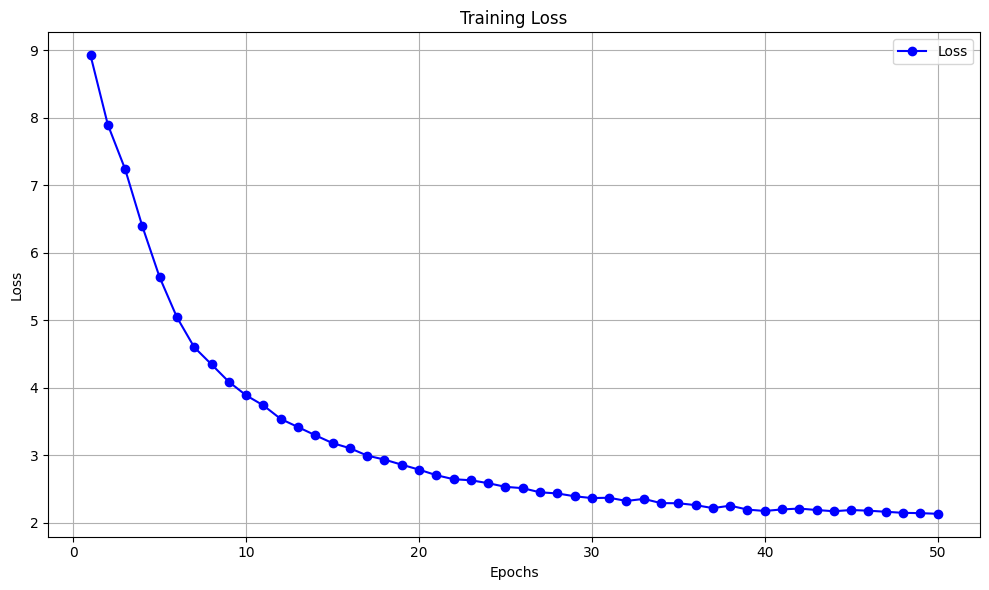

In [27]:
plot_training_history(history['loss_history'])

# Save model

In [32]:
# Save the trained model to an H5 file
model.save("gru4rec_model.h5")

# Test Load model

In [33]:
from tensorflow.keras.models import load_model

loaded_model = load_model(
    "gru4rec_model.h5"
)

ValueError: Unknown layer: 'GRU4REC'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.